# Jorge Bueno Perez & Noam Shmuel

# Text Mining and Social Media Mining, final project 
# Sentiment analysis performed on the transcripts and titles of youtube videos related to the game Cyberpunk 2077

# Importing packages and data:

In [1]:
import pandas as pd
import numpy as np
import re
import librosa
import matplotlib.pyplot as plt
import librosa.display
import random
import datetime
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
cyber= pd.read_csv("~/Desktop/Projects/Text mining/Audio analysis/cyberpunk.csv")

In [3]:
cyber.head()

,url,description,duration,views,transcript,rating,duration_min,is_liked
0,https://www.youtube.com/watch?v=0UiXx-_fL5U,Cyberpunk 2077 Review - The Best Unfinished Ga...,28:43,105676,[{'transcript': 'so I get a lot of questions a...,4.864700,28.72,1
1,https://www.youtube.com/watch?v=QcH9c_rJItE,Cyberpunk 2077 - Easy Allies Review,13:34,22384,"[{'transcript': ""how does cyberpunk 2077 on th...",4.870146,13.57,1
2,https://www.youtube.com/watch?v=QfpoTjUz1BY,Cyberpunk 2077 for Xbox One and PlayStation 4 ...,3:49,922825,"[{'transcript': ""this is a real blood of my cy...",4.836886,3.82,0
3,https://www.youtube.com/watch?v=FPzMhniHikQ,A Brutally Honest Review Of Cyberpunk 2077,10:36,18784,"[{'transcript': ""what is going on your nation ...",4.854014,10.60,1
4,https://www.youtube.com/watch?v=z1rUP17fayA,Cyberpunk 2077 PC Review (With New Gameplay),9:00,1306680,[{'transcript': 'what the what the hell are yo...,4.627821,9.00,0


# 1) `General analysis`

In [4]:
duration_min= []
for i in range(len(cyber.duration)):
    if len(cyber.duration[i]) == 4:
        duration_min.append(round(int(cyber.duration[i][:1]) + int(cyber.duration[i][2:]) / 60, 2))
    elif len(cyber.duration[i]) == 5:
        duration_min.append(round(int(cyber.duration[i][:2]) + int(cyber.duration[i][3:]) / 60, 2))
    elif len(cyber.duration[i]) == 7:
        duration_min.append(round(int(cyber.duration[i][:1]) * 60 + int(cyber.duration[i][2:4]) + int(cyber.duration[i][5:]) / 60, 2))
    else:
        print("Error!")

In [5]:
cyber["duration_min"] = duration_min

In [6]:
cyber.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,views,rating,duration_min,is_liked
count,136.00000,136.00000,136.00000,136.00000
mean,344604.53676,4.70179,21.98279,0.50735
std,574313.02166,0.43867,37.95599,0.50179
min,21.00000,1.97797,2.78000,0.00000
25%,30456.00000,4.68752,9.03750,0.00000
50%,108768.00000,4.85315,12.00000,1.00000
75%,491924.75000,4.91621,19.86250,1.00000
max,3681416.00000,5.00000,300.02000,1.00000


# 2) Some `audio analysis`:

### The package `librosa` allows to `visualize the audio in a graph`. In this case a `random audio` will be visualized, below the `audio number 75` is presented

75


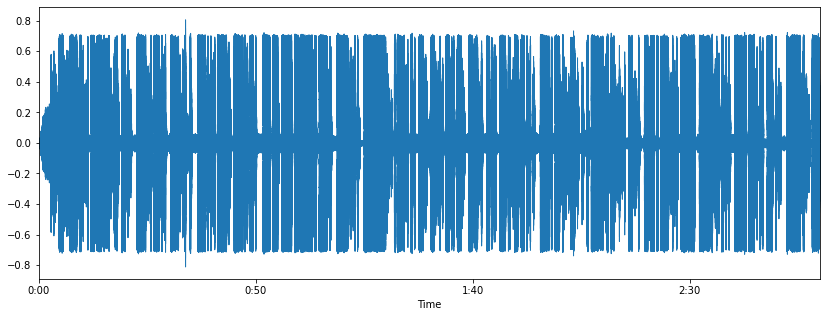

In [7]:
%matplotlib inline
plt.figure(figsize=(14, 5))
r= random.randint(0, len(cyber.url))
audio_data = "/Users/Lajobu/Desktop/Projects/Text mining/Audio analysis/Audios/" + str(re.sub(re.compile("[/:?.]"), "", cyber.url[r])) + ".wav"
x , sr= librosa.load(audio_data, duration= 180)
librosa.display.waveplot(x, sr=sr)
print(r)
plt.savefig('/Users/Lajobu/Desktop/Projects/Text mining/Audio analysis/Figures/audio_graph.png')

### This package also allows to visualize a `spectrogram`, this is a way of plotting the `signal strength`

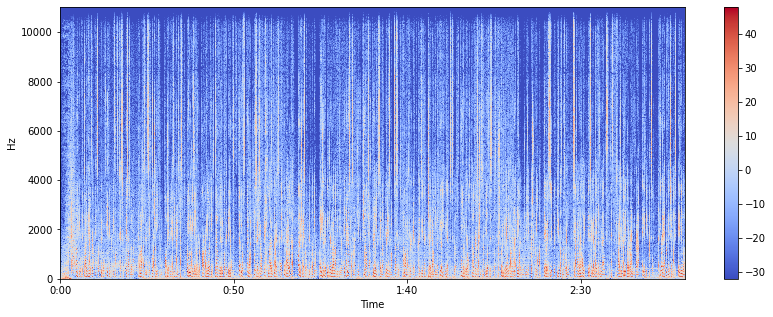

In [8]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.savefig('/Users/Lajobu/Desktop/Projects/Text mining/Audio analysis/Figures/audio_graph1.png')

# 3) Analyzing `rating` feature:

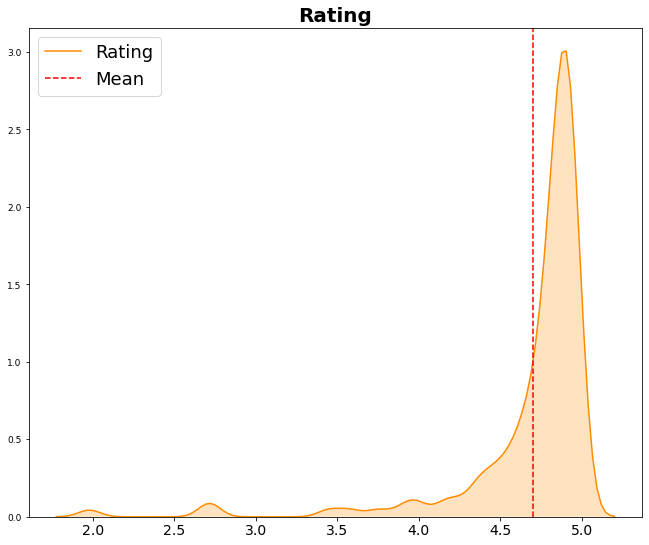

In [9]:
fig, ax =plt.subplots(figsize=(11,9))
plot = sns.kdeplot(cyber.rating, shade=True, color="darkorange")
plot.tick_params(axis='x', labelsize=14)
plot.tick_params(axis='y', labelsize=9)
plot.set_title("Rating", fontsize=20, fontweight="bold")
plot.axvline(cyber.rating.mean(), color='r', linestyle='--')
plt.legend({'Rating': cyber.rating, 'Mean': cyber.rating.mean()}, fontsize=18)
plt.show()
fig.savefig('/Users/Lajobu/Desktop/Projects/Text mining/Audio analysis/Figures/rating_distribution.png')

### As we can see, the `mean` is more or less `4.7`

### The `median` seems to be around `4.85`

In [10]:
cyber.rating.median()

4.853154399999999

# 4) Feature enginering, `is_liked`:

### For the purpose of this analysis, the feature `is_liked` will be created based om the column `rating`. This new variable is one of the most important features used in `sentiment analysis`

### This new feature will be created as per the below `conditions`:
### - `Rating between 4.85 and 5 `- Liked video - Greater than the median - `value= 1`
### - `Rating lower than or equal to 4.85` - Not liked video - Lower than or equal to the median - `value= 0`

### The split was done as per above conditions, due to the fact that it is `not common to find a video with more dislikes than likes`, also with the `median` we will be sure the data is `balanaced`

In [11]:
is_liked= []
for i in cyber.rating:
    if (i > 4.85):
        is_liked.append(1) 
    else:
        is_liked.append(0) 
cyber["is_liked"] = is_liked

### It looks like there are slighty more `liked` videos than `not liked` videos:

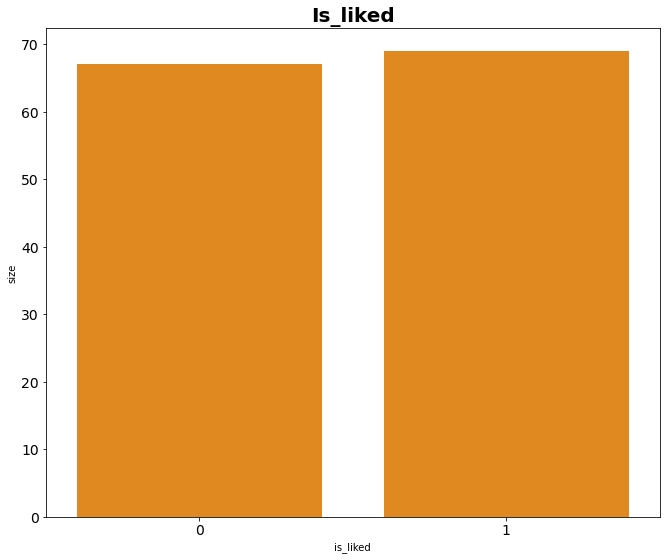

In [12]:
df= cyber.filter(["is_liked"]).groupby(["is_liked"], as_index=False).size().sort_values(['size'], ascending= False)[:7].sort_values("size", ascending=False)

fig, ax =plt.subplots(figsize=(11,9))
plot = sns.barplot(x="is_liked", y=str("size"), data=df, label="Total", color= "darkorange")
plot.set_title("Is_liked", fontsize=20, fontweight="bold")
plot.tick_params(axis='x', labelsize=14)
plot.tick_params(axis='y', labelsize=14)
fig.savefig('/Users/Lajobu/Desktop/Projects/Text mining/Audio analysis/Figures/is_liked_distribution.png')

# 5) `Correlation` between variables:

### It looks like there is `only positive correlation`, however it `doesn't seem high`

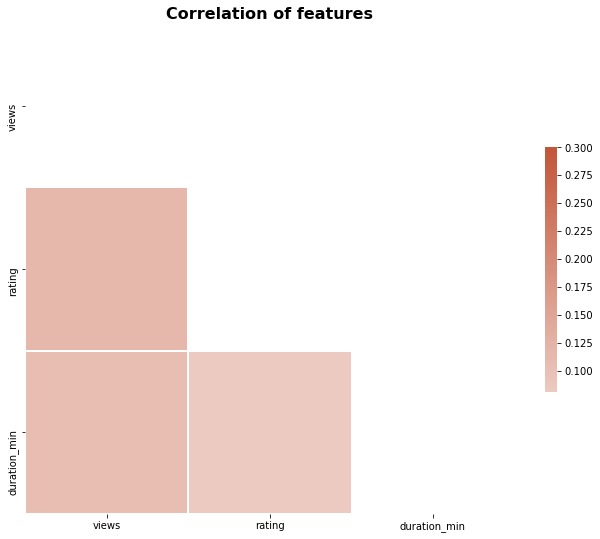

In [13]:
corr = cyber.loc[:, cyber.columns != 'is_liked'].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation of features',
            fontsize=16,
            fontweight='bold')
fig.savefig('/Users/Lajobu/Desktop/Projects/Text mining/Audio analysis/Figures/corr_plot.png')

# 6) Most `common words in transcript`:

### Now a `wordcloud` with the most common words in `transcript` will be created for both categories: `liked` and `not_liked`

In [14]:
stopwords = set(STOPWORDS)

stopwords.add("cyberpunk")
stopwords.add("video")
stopwords.add("game")
stopwords.add("transcript'")
stopwords.add("know")
stopwords.add("going")
stopwords.add("confidence'")

liked = WordCloud(stopwords=stopwords,
                      background_color='black',
                      width=3000,
                      height=2500).generate(' '.join(cyber[cyber.is_liked == 1].transcript))
not_liked= WordCloud(stopwords=stopwords,
                      background_color='black',
                      width=3000,
                      height=2500).generate(' '.join(cyber[cyber.is_liked == 0].transcript))

### It seems one of the most common words in the `transcript` with `liked` are `play` and `want`

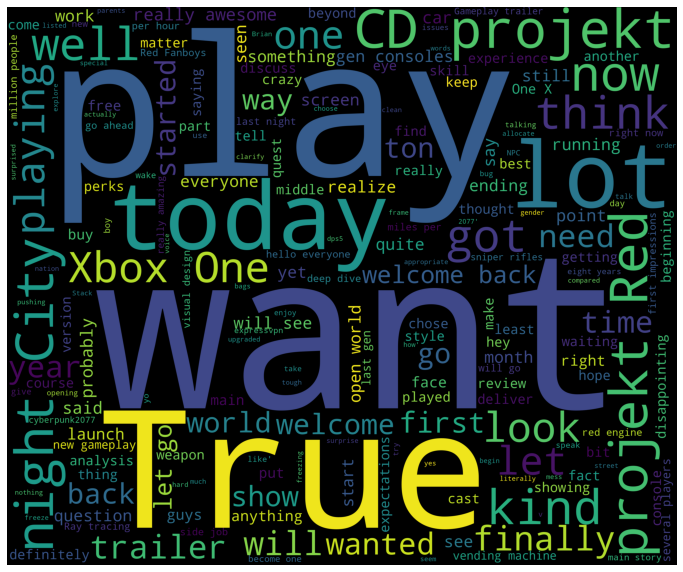

<Figure size 432x288 with 0 Axes>

In [15]:
plt.figure(1,figsize=(12, 12))
plt.imshow(liked)
plt.axis('off')
plt.show()
plt.savefig('/Users/Lajobu/Desktop/Projects/Text mining/Audio analysis/Figures/words_liked_trans.png')

### It seems the one of the most common words in the `transcript` with `not_liked` are `time` and `CD projekt`

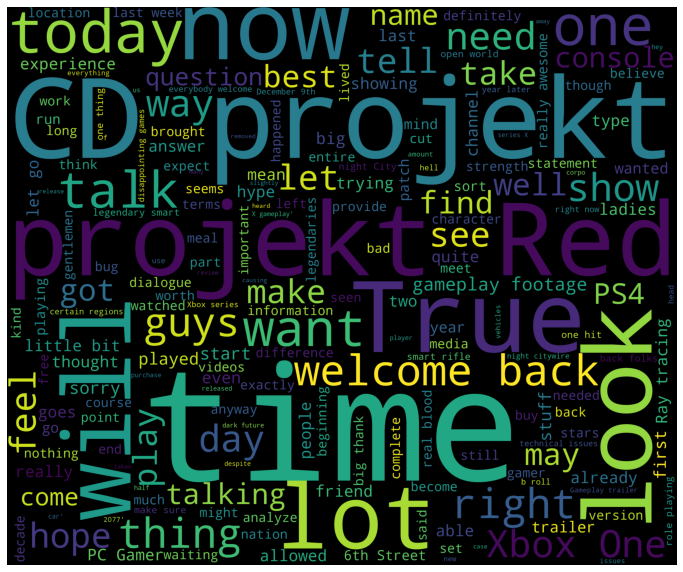

<Figure size 432x288 with 0 Axes>

In [16]:
plt.figure(1,figsize=(12, 12))
plt.imshow(not_liked)
plt.axis('off')
plt.show()
plt.savefig('/Users/Lajobu/Desktop/Projects/Text mining/Audio analysis/Figures/words_not_liked_trans.png')

# 7) Most `common words in the title` of the video:

### Now a `wordcloud` will be created with the most common words in `description` for both categories `liked` and `not_liked`

In [17]:
stopwords = set(STOPWORDS)

stopwords.add("cyberpunk")
stopwords.add("video")
stopwords.add("game")
stopwords.add("transcript'")
stopwords.add("know")
stopwords.add("going")
stopwords.add("confidence'")
stopwords.add("gameplay")
stopwords.add("review")

liked = WordCloud(stopwords=stopwords,
                      background_color='black',
                      width=3000,
                      height=2500).generate(' '.join(cyber[cyber.is_liked == 1].description))
not_liked= WordCloud(stopwords=stopwords,
                      background_color='black',
                      width=3000,
                      height=2500).generate(' '.join(cyber[cyber.is_liked == 0].description))

### It seems the one of the most common words in the `title` with `liked` are `Best` and `Analysis`

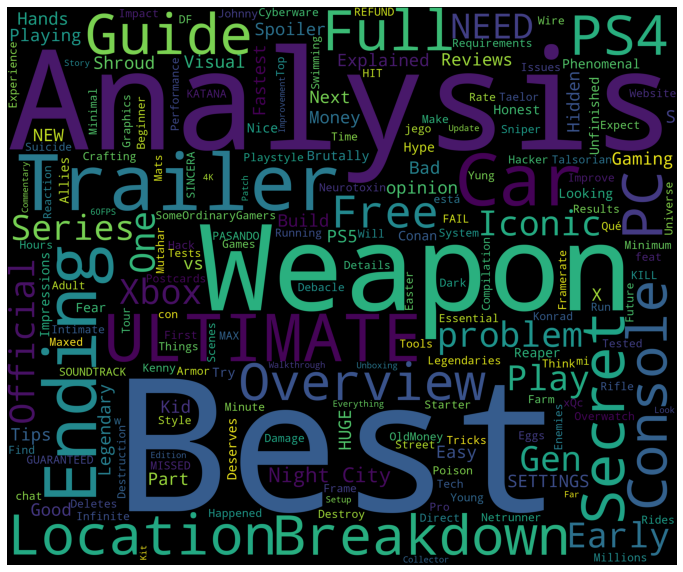

<Figure size 432x288 with 0 Axes>

In [18]:
plt.figure(1,figsize=(12, 12))
plt.imshow(liked)
plt.axis('off')
plt.show()
plt.savefig('/Users/Lajobu/Desktop/Projects/Text mining/Audio analysis/Figures/words_liked_desc.png')

### It seems the one of the most common words in the `title` with `not_liked` are `PC` and `PS5`

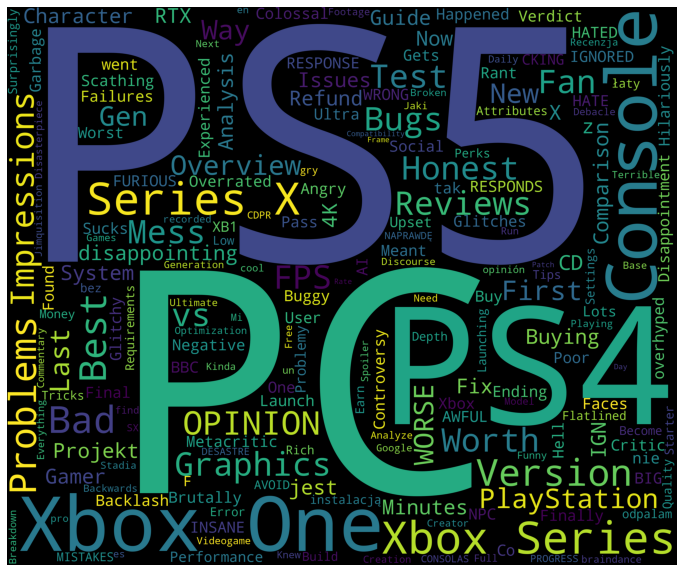

<Figure size 432x288 with 0 Axes>

In [19]:
plt.figure(1,figsize=(12, 12))
plt.imshow(not_liked)
plt.axis('off')
plt.show()
plt.savefig('/Users/Lajobu/Desktop/Projects/Text mining/Audio analysis/Figures/words_not_liked_desc.png')

In [20]:
#cyber.to_csv("~/Desktop/Projects/Text mining/Audio analysis/cyberpunk.csv", index=False)